<b>#-----------------------------------------Healthcare dataset -----------------------------------------------#</b>

<b>--------------------------------Import Libraries------------------------------</b>

In [183]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from sklearn.utils import resample

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay
from sklearn.metrics import precision_score,recall_score,f1_score,classification_report,roc_curve,plot_roc_curve,auc,precision_recall_curve,plot_precision_recall_curve,average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix

from imblearn.over_sampling import SMOTE

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [184]:
# Init : Variables
now = datetime.now() # current date and time

In [185]:
df = pd.read_csv('DataSources/healthcare-dataset-stroke-data.csv')

<b>#########################################DATA VISUALIZATION######################################</b>

In [186]:
# Hypertension is the most prevalent risk factor for stroke
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6659031/
ht_dataset = df.loc[ ( df['stroke'] == 1 ) & ( df['hypertension'] == 1 )] # Just 66 HyperTension Patients of 5110 Rows - Will lead to  skewed Stroke Detection
len(ht_dataset)

66

In [187]:
 # Coronary artery disease increases your risk for stroke, because plaque builds up in the arteries and blocks the flow of oxygen-rich blood to the brain
hd_dataset = df.loc[ ( ( df['stroke'] == 1 ) & df['heart_disease'] == 1 ) ] # Just 47 Heart Disease Patients of 5110 Rows - Will lead to  skewed Stroke Detection
len(hd_dataset)

47

<b>#########################################DATA CLEANING##########################################</b>

<b>-------------------------------Functions------------------------------------</b>

In [188]:
def get_stacked_bar_chart(column):
    # Get the count of records by column and stroke    
    df_pct = df.groupby([column, 'stroke'])['age'].count()
    # Create proper DataFrame's format
    df_pct = df_pct.unstack()    
    return df_pct.plot.bar(stacked=True, figsize=(6,6), width=1);
def get_100_percent_stacked_bar_chart(column, width = 0.5):
    # Get the count of records by column and stroke
    df_breakdown = df.groupby([column, 'stroke'])['age'].count()
    # Get the count of records by gender
    df_total = df.groupby([column])['age'].count()
    # Get the percentage for 100% stacked bar chart
    df_pct = df_breakdown / df_total * 100
    # Create proper DataFrame's format
    df_pct = df_pct.unstack()
    return df_pct.plot.bar(stacked=True, figsize=(6,6), width=width);
def classification_eval(y_test, y_pred):
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test,y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'null accuracy = {round(max(y_test.mean(), 1 - y_test.mean()), 2)}')

<b>---------------------Check Data Types------------------------</b>

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


<b>----------------------Clean & Remove Unwanted Values--------------------------</b>

In [190]:
# ------------------------Gender ----------------------------#
# 1. There were 1 patients who were categorized as ‘Other’ in the gender column. 
# 2. They were dropped because their size was insignificant to the dataset 
genderRows = df[df['gender'] == 'Other'].index 
df.drop(genderRows, inplace=True)

<b>-----------------Identify Missing Values using Descriptive Statistics------------------------------</b>

In [191]:
# bmi count is less than dataset
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,4908.00000,5109.000000
mean,36513.985516,43.229986,0.097475,0.054022,106.140399,28.89456,0.048738
std,21162.008804,22.613575,0.296633,0.226084,45.285004,7.85432,0.215340
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,17740.000000,25.000000,0.000000,0.000000,77.240000,23.50000,0.000000
50%,36922.000000,45.000000,0.000000,0.000000,91.880000,28.10000,0.000000
75%,54643.000000,61.000000,0.000000,0.000000,114.090000,33.10000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


In [192]:
# Missing Values 201 bmi rows with nulls
df['bmi'].isnull().sum()

201

<b>------------------------------Data Anamolies-----------------------------------</b>

In [193]:
# smoking_status different kind of values. 
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [194]:
# Significant level of unknown values - 1544
df.loc[df['smoking_status'] == 'Unknown']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
23,64778,Male,82.0,0,1,Yes,Private,Rural,208.30,32.5,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5098,579,Male,9.0,0,0,No,children,Urban,71.88,17.5,Unknown,0
5101,36901,Female,45.0,0,0,Yes,Private,Urban,97.95,24.5,Unknown,0
5103,22127,Female,18.0,0,0,No,Private,Urban,82.85,46.9,Unknown,0
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0


<b>-----------------------Fix Missing Values(BMI) - Imputation----------------------------------</b>

In [195]:
# Only 201/1544 (13%) null rows so can just use mean 
mean_value = df['bmi'].mean()
df['bmi'].fillna(mean_value, inplace = True)

<b>#########################################DATA REDUCTION##########################################</b>

<b>--------------------Remove Non-Critical Columns--------------------------</b>

<AxesSubplot:xlabel='gender'>

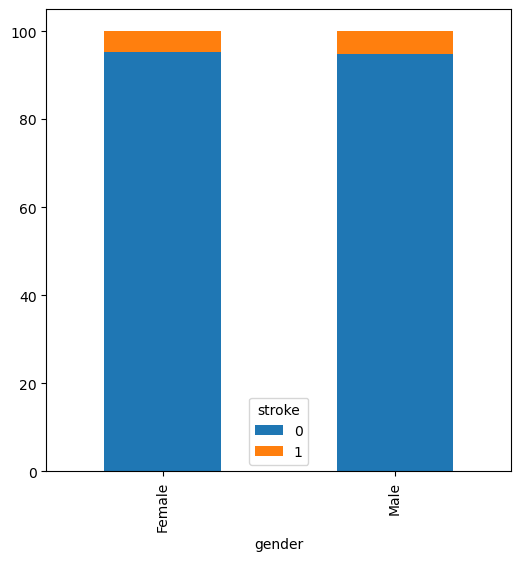

In [196]:
# Regardless of patient’s gender, and where they stayed, they have the same likelihood to experience stroke
get_100_percent_stacked_bar_chart('gender')

<AxesSubplot:xlabel='Residence_type'>

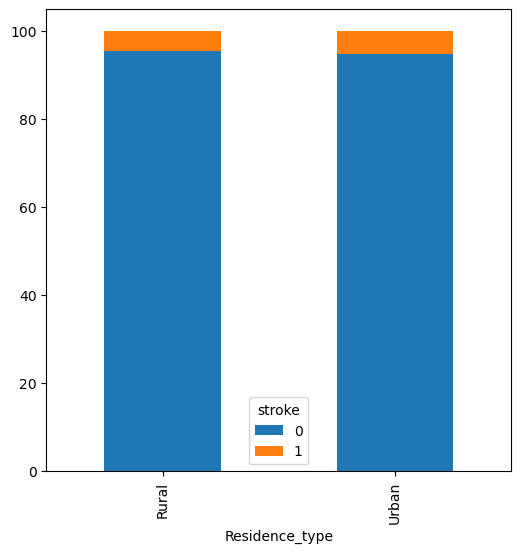

In [197]:
# Regardless of patient’s residence Type, and where they stayed, they have the same likelihood to experience stroke
get_100_percent_stacked_bar_chart('Residence_type')

In [198]:
# drop insignificant columns
df.drop(columns=['gender'], inplace=True)
df.drop(columns=['Residence_type'], inplace=True)

age           
              count       mean
work_type                     
Govt_job        657  50.879756
Never_worked     22  16.181818
Private        2924  45.510602
Self-employed   819  60.201465
children        687   6.841339

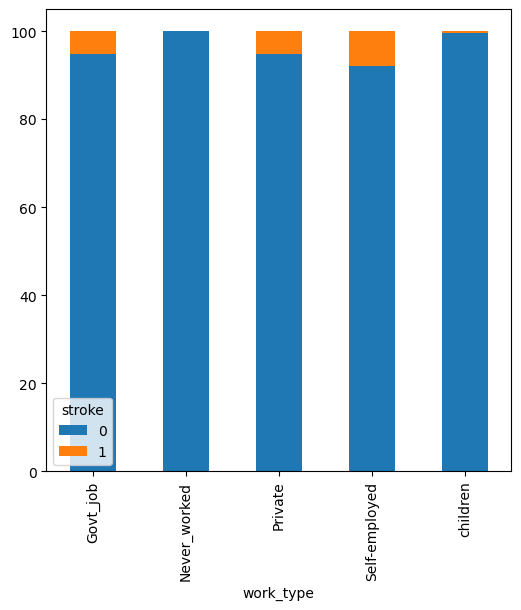

In [199]:
get_100_percent_stacked_bar_chart('work_type')
df.groupby(['work_type'])[['age']].agg(['count', 'mean'])

In [200]:
# Observations 
# 1. Proportion of patient who was self-employed and suffered a stroke was relatively higher than other categories. However, this variable was highly associated with age. Mean Age : 60+
# 2. Proportion of Work Types : never_worked and children is self explanatory, has no association with stroke patients
# 3. Propertion of govt_job patients also have a mean Age of 50_ years. 
# 4. Since Fourt of Work Types have close association with patients age , work_type was dropped

In [201]:
df.drop(columns=['work_type'], inplace=True)

<b>-------------Identify Outliers--------------------------------</b>

In [202]:
#features like cholesterol and resting blood pressure present atypical cases
def detect_outliers(label=None):
    #The interquartile range (IQR) measures the spread of the middle half of your data. It is the range for the middle 50% of your sample
    Q1 = df[label].quantile(0.25)
    Q3 = df[label].quantile(0.75)
    IQR = Q3 - Q1
    interval = ((df[label] > Q1 - 1.5*IQR) & (df[label] < Q3 + 1.5*IQR))
    return df[interval], df[~interval]

def delete_outliers(df_out):
    return df.drop(df_out.index)

Text(0.5, 1.0, 'Blood Glucose Level (mg/dL)')

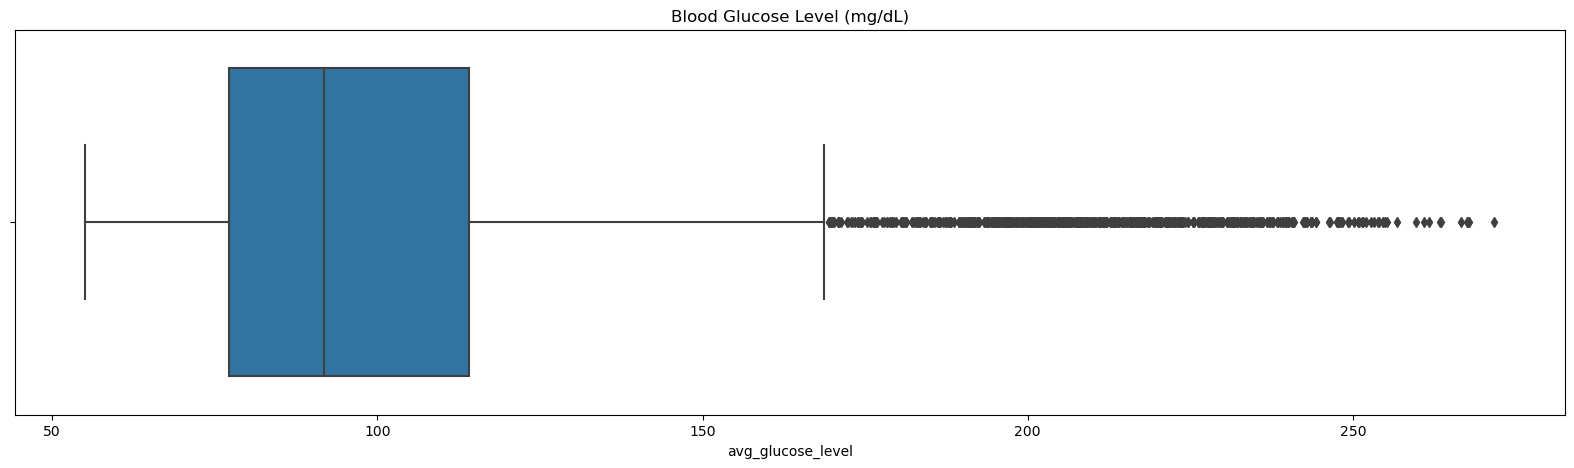

In [203]:
#Visualize Outlier - avg_glucose_level
plt.figure(figsize=(20,5))
sns.boxplot(data=df, x="avg_glucose_level")
plt.title('Blood Glucose Level (mg/dL)')

<AxesSubplot:xlabel='bmi'>

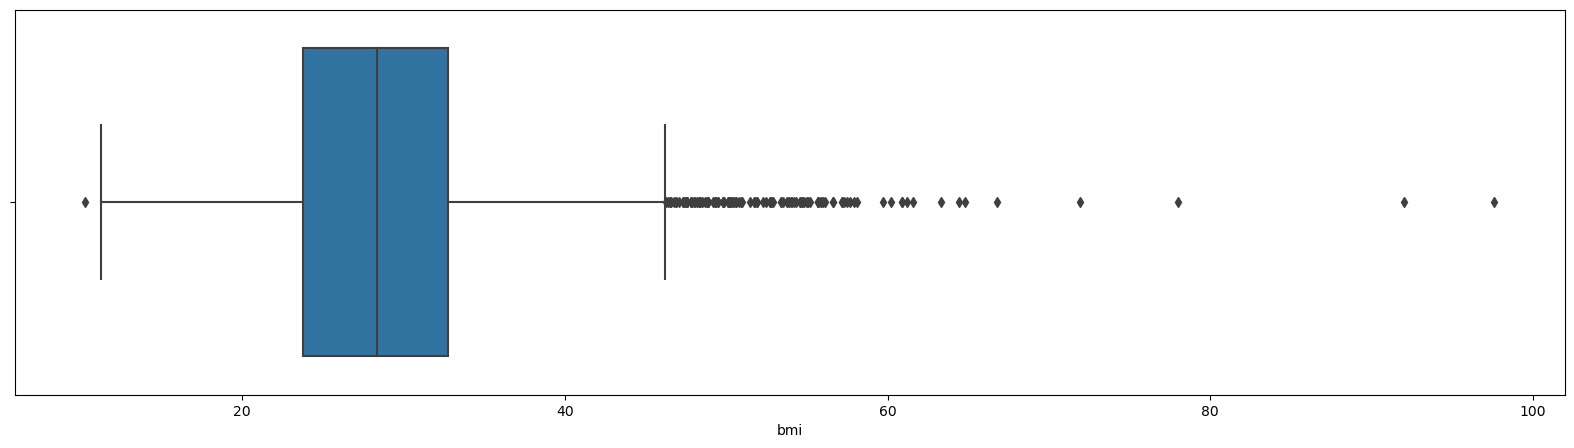

In [204]:
#Visualize Outlier - bmi
plt.figure(figsize=(20,5))
sns.boxplot(data=df, x="bmi")

In [205]:
# Detect Outliers - 
not_outliers_glucose, outliers_glucose = detect_outliers('avg_glucose_level')
not_outliers_bmi, outliers_bmi = detect_outliers('bmi')
print(f'Outliers in Glucose represent the {round((outliers_glucose.shape[0]*100)/df.shape[0], 2)}% of our dataset')
print(f'Outliers in bmi represent the {round((outliers_bmi.shape[0]*100)/df.shape[0], 2)}% of our dataset')

Outliers in Glucose represent the 12.27% of our dataset
Outliers in bmi represent the 2.47% of our dataset


<b>------------------------------------Fix Outliers----------------------</b>

In [206]:
# Outliers - Balancing 
from sklearn.ensemble import IsolationForest
iso = IsolationForest(n_estimators = 1000, contamination = 0.03)
  # the contamination value determines the outlier cut-off value
  # we can adjust this value to ensure we do not further 
  # imbalance our target
outs = pd.Series(iso.fit_predict(df[['bmi', 'avg_glucose_level']]), name = 'outliers')
outs.value_counts()

 1    4955
-1     154
Name: outliers, dtype: int64

In [207]:
# Outliers - Remove
df = pd.concat([outs.reset_index(), df.reset_index()], axis = 1,
               ignore_index = False).drop(columns = 'index')
df = df[df['outliers'] == 1]
df['stroke'].value_counts()

0    4718
1     237
Name: stroke, dtype: int64

In [208]:
not_outliers_glucose, outliers_glucose = detect_outliers('avg_glucose_level')
not_outliers_bmi, outliers_bmi = detect_outliers('bmi')
print(f'Outliers in Glucose represent the {round((outliers_glucose.shape[0]*100)/df.shape[0], 2)}% of our dataset')
print(f'Outliers in bmi represent the {round((outliers_bmi.shape[0]*100)/df.shape[0], 2)}% of our dataset')

Outliers in Glucose represent the 10.92% of our dataset
Outliers in bmi represent the 1.11% of our dataset


<b>########################################DATA TRANSFORMATION###################################################</b>

<b>----------------------Data Scaling--------------------------</b>

In [209]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# num_cols = ['age', 'avg_glucose_level', 'bmi']
# df[num_cols] = ss.fit_transform(df[num_cols])

<b>-----------------Handle Imbalanced Data  ( Resample )-----------------------------</b>

In [210]:
# Highly Imbalanced Data , only 4.75% of Dataset is related to Stroke Occurence
# Hence Minority Class Dataset with Stroke = 1 needs to be oversampled
df['stroke'].value_counts()

0    4718
1     237
Name: stroke, dtype: int64

In [211]:
ts = ( 249/5109 ) * 100
ts

4.873752201996477

In [212]:
tns = ( 4860/5109 ) * 100
tns

95.12624779800353

In [213]:
data_majority = df[(df['stroke'] == 0)]
data_minority = df[(df['stroke'] == 1)]
from sklearn.utils import resample
data_minority_resampled = resample(data_minority, n_samples=4861, random_state = 42)
df = pd.concat([data_majority, data_minority_resampled])
df = df.sample(frac = 1, random_state = 42).reset_index(drop = True)

In [214]:
# Post Resampling
hs_dataset = df.loc[ ( df['stroke'] == 1 )] # Just 66 HyperTension Patients of 5110 Rows - Will lead to  skewed Stroke Detection
ts = len(hs_dataset) /len(df.index)
print(ts * 100)

50.746424470195215


In [215]:
hs_dataset = df.loc[ ( df['stroke'] == 0 )] # Just 66 HyperTension Patients of 5110 Rows - Will lead to  skewed Stroke Detection
tns = len(hs_dataset) /len(df.index)
print(tns * 100)

49.253575529804785


In [216]:
ht_dataset = df.loc[ ( df['stroke'] == 1 ) & ( df['hypertension'] == 1 )] # Just 66 HyperTension Patients of 5110 Rows - Will lead to  skewed Stroke Detection
t = len(ht_dataset) /len(df.index)
print(t * 100)

12.276855621672409


In [217]:
 # Coronary artery disease increases your risk for stroke, because plaque builds up in the arteries and blocks the flow of oxygen-rich blood to the brain
hd_dataset = df.loc[ ( ( df['stroke'] == 1 ) & df['heart_disease'] == 1 ) ] # Just 47 Heart Disease Patients of 5110 Rows - Will lead to  skewed Stroke Detection
t = len(hd_dataset) /len(df.index)
print(t * 100)

9.165883703935693


In [218]:
#  Post ReSample - 9580 rows 
df.info() # New Count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9579 entries, 0 to 9578
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   outliers           9579 non-null   int32  
 1   id                 9579 non-null   int64  
 2   age                9579 non-null   float64
 3   hypertension       9579 non-null   int64  
 4   heart_disease      9579 non-null   int64  
 5   ever_married       9579 non-null   object 
 6   avg_glucose_level  9579 non-null   float64
 7   bmi                9579 non-null   float64
 8   smoking_status     9579 non-null   object 
 9   stroke             9579 non-null   int64  
dtypes: float64(3), int32(1), int64(4), object(2)
memory usage: 711.1+ KB


<b>----------------------------------Apply Encoding----------------------------------</b>

In [219]:
coder = LabelEncoder()
df['ever_married'] = coder.fit_transform(df['ever_married'])
df['smoking_status'] = coder.fit_transform(df['smoking_status'])

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9579 entries, 0 to 9578
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   outliers           9579 non-null   int32  
 1   id                 9579 non-null   int64  
 2   age                9579 non-null   float64
 3   hypertension       9579 non-null   int64  
 4   heart_disease      9579 non-null   int64  
 5   ever_married       9579 non-null   int32  
 6   avg_glucose_level  9579 non-null   float64
 7   bmi                9579 non-null   float64
 8   smoking_status     9579 non-null   int32  
 9   stroke             9579 non-null   int64  
dtypes: float64(3), int32(3), int64(4)
memory usage: 636.2 KB


<b>--------------Separate out Independent Variables & Dependent Variables (Features)-------------------------------------</b>

In [221]:
#X = df.drop(columns = ['stroke', 'id'])
X = df.drop(columns = ['outliers', 'stroke', 'id'])
y = df.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y)

<b>#################################################MODEL TRAINING & TEST RUNS###############################################</b>

<b>------------------------------------------Model Metrics - Understanding ------------------------------------</b>

In [222]:
# Modeling Strategy 
# Case Negative : Patients with "No CVD" or No Condition ( NC)
# Case Positive : Patients with "CVD"
# TN : The prediction tells us that the patient has NC when actually has NC.
# TP: The prediction tells us that the patient has CVDs when actually has CVDs.
# FN: The prediction tells us that the patient has NC when actually has CVDs. ( Worst Case )
# FP: The prediction tells us that the patient has CVDs when actually has NC.

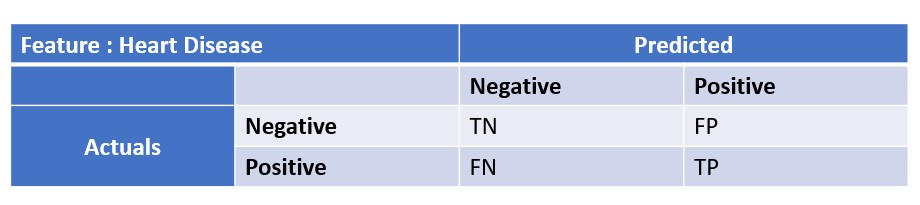

In [223]:
# Important Model Scores

# 1. Accuracy : Accuracy tells you how many times the ML model was correct overall.
#    100 Predictions, 73 are correct, accuracy is 73%

# 2. Precision : Model metric we use to select our best model when there is a high cost associated with False Positive (FP) 
#    When the costs of False Positive is high. For instance, email spam detection. 
#    In email spam detection, a false positive means that an email that is non-spam (actual negative) has been predicted as spam (predicted spam).  

# 3. Recall :  Model metric we use to select our best model when there is a high cost associated with False Negative (FN) 
#    If a fraudulent transaction (Actual Positive) is predicted as non-fraudulent (Predicted Negative)

# 4. F1-Score  :  The accuracy metric computes how many times a model made a correct prediction across the entire dataset
#    Performance measure for classification and often preferred over, for example, accuracy when data is unbalanced

<b>-------------------------------------Setting up Models with Algorithms------------------------------------------</b>

In [224]:
# Print Current DateTime
current_date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
models = []
models.append(['XGBClassifier',XGBClassifier(learning_rate=0.1,objective='binary:logistic',random_state=0,eval_metric='mlogloss')])
models.append(['Logistic Regression',LogisticRegression(random_state=0)])
models.append(['SVM',SVC(random_state=0)])
models.append(['KNeigbors',KNeighborsClassifier()])
#models.append(['GaussianNB',GaussianNB()])
models.append(['BernoulliNB',BernoulliNB()])
models.append(['DecisionTree',DecisionTreeClassifier()])
models.append(['RandomForest',RandomForestClassifier(n_estimators=100)])
models.append(['AdaBoostClassifier',AdaBoostClassifier()])

<b>-------------------------------------Compute Model Performance Matrix ------------------------------------------</b>

=================================Model:XGBClassifier : 05/29/2023, 11:20:40 =====================================


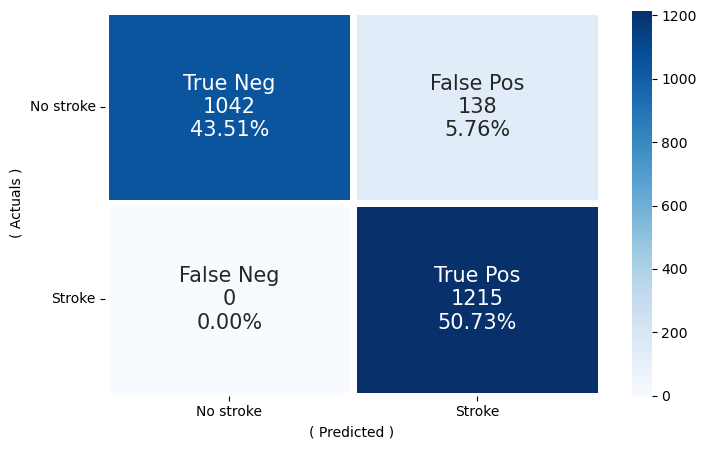

=================================Model:Logistic Regression : 05/29/2023, 11:20:40 =====================================


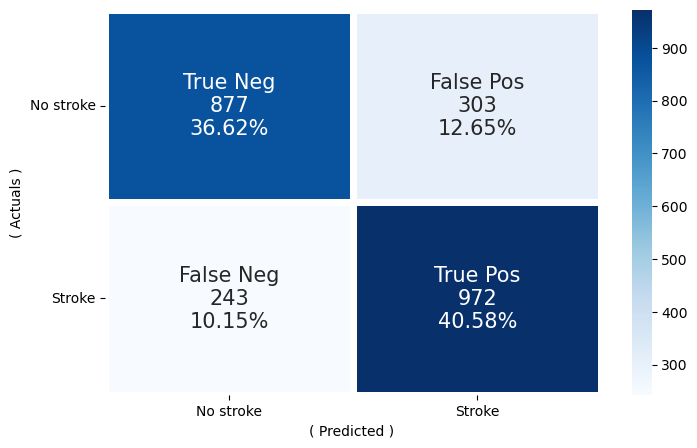

=================================Model:SVM : 05/29/2023, 11:20:40 =====================================


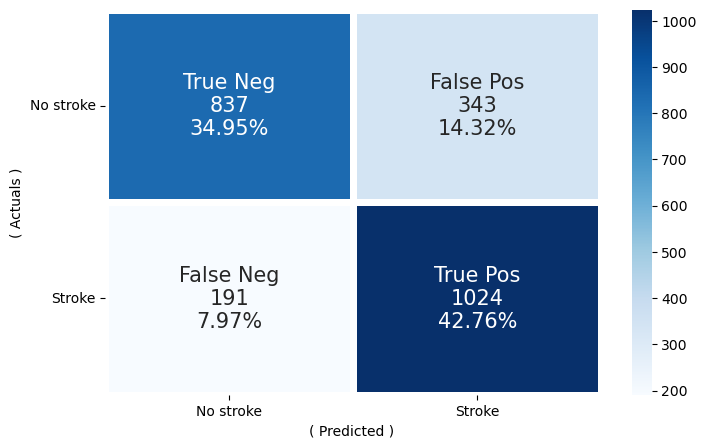

=================================Model:KNeigbors : 05/29/2023, 11:20:40 =====================================


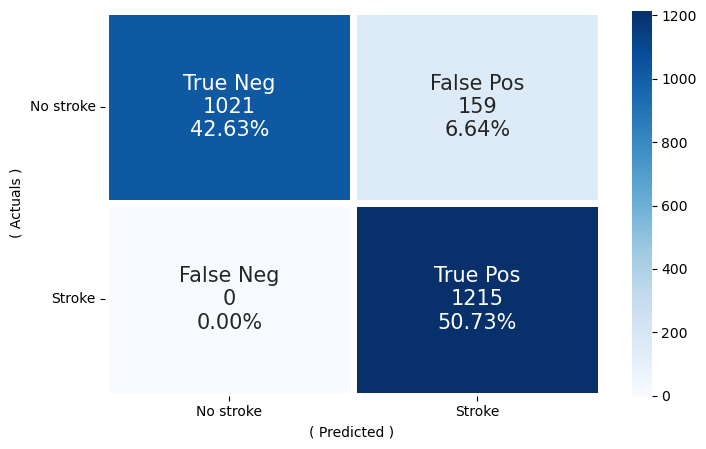

=================================Model:BernoulliNB : 05/29/2023, 11:20:40 =====================================


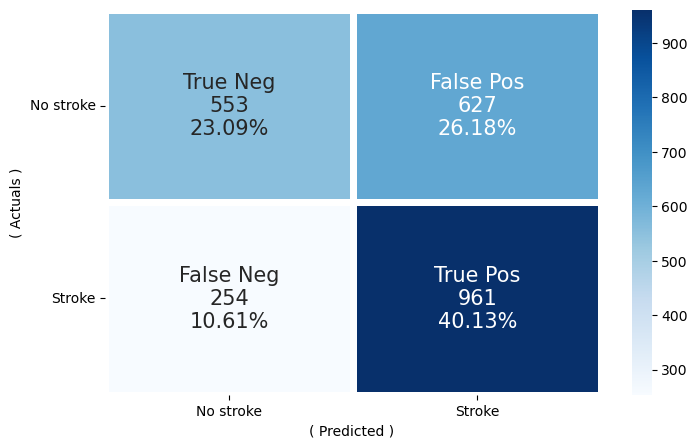

=================================Model:DecisionTree : 05/29/2023, 11:20:40 =====================================


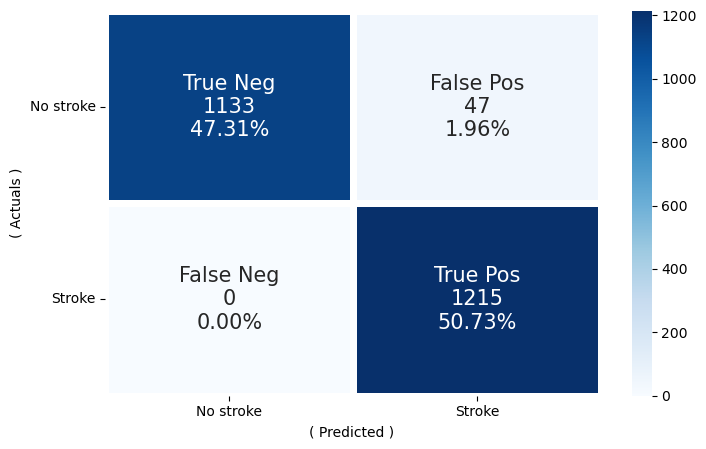

=================================Model:RandomForest : 05/29/2023, 11:20:40 =====================================


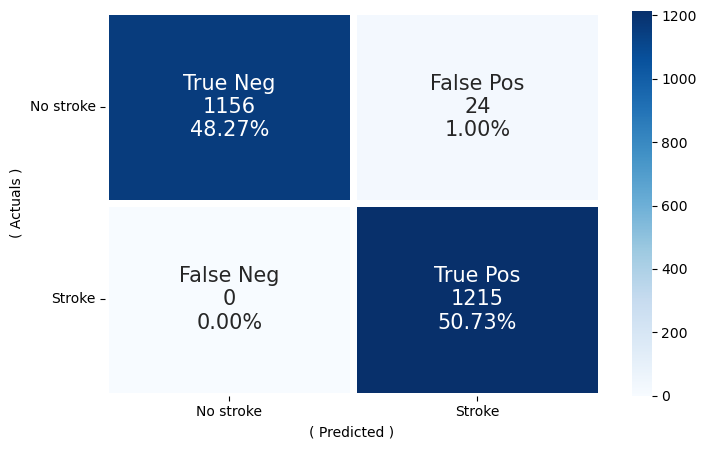

=================================Model:AdaBoostClassifier : 05/29/2023, 11:20:40 =====================================


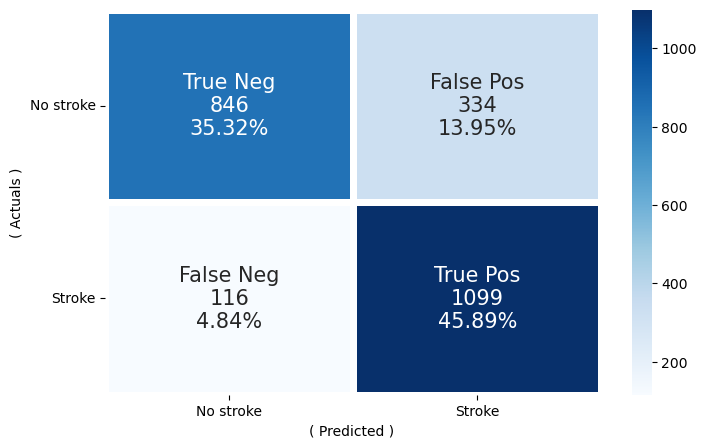

In [225]:
lst_1 = []
for m in range(len(models)):
    lst_2 = []
    model = models[m][1]
    modelName = models[m][0]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
   
    accuracies = cross_val_score(estimator= model, X = X_train,y = y_train, cv=10)
    
    # Visualizing Confusion Matrix
    cm = confusion_matrix(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (8, 5))
    ax = sns.heatmap(cm, cmap = 'Blues', annot=labels, fmt = '', linewidths = 5, cbar = True, annot_kws = {'fontsize': 15}, 
                yticklabels = ['No stroke', 'Stroke'], xticklabels = ['No stroke', 'Stroke'])
    ax.set_xlabel('( Predicted ) ')
    ax.set_ylabel('( Actuals )');
    plt.yticks(rotation = 0)
    txt =  "=================================Model:{0} : {1} ====================================="
    print(txt.format(modelName, current_date_time))
    plt.show()

# k-fOLD Validation
    roc = roc_auc_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    lst_2.append(models[m][0])
    lst_2.append(accuracy_score(y_test,y_pred)*100)
    #lst_2.append(accuracies.mean()*100)
    #lst_2.append(accuracies.std()*100)
    #lst_2.append(roc)
    lst_2.append(precision)
    lst_2.append(recall)
    lst_2.append(f1)
    lst_1.append(lst_2)

In [226]:
# Output the Models Performance Metrics

df2 = pd.DataFrame(lst_1,columns=['Model','Accuracy','Precision','Recall','F1 Score'])

# Type II Errors - False Negatives Take Precedence
# High precision and high recall are desirable, but there may be a trade-off between the two metrics in some cases.
# If a Stroke (Actual Positive) is predicted as No Stroke (Predicted Negative) it can be fatal 
df2.sort_values(by=['Accuracy', 'Recall'],inplace=True,ascending=False)
df2

,Model,Accuracy,Precision,Recall,F1 Score
6,RandomForest,98.997912,0.980630,1.000000,0.990220
5,DecisionTree,98.037578,0.962758,1.000000,0.981025
0,XGBClassifier,94.237996,0.898004,1.000000,0.946262
3,KNeigbors,93.361169,0.884279,1.000000,0.938586
7,AdaBoostClassifier,81.210856,0.766923,0.904527,0.830060
2,SVM,77.703549,0.749086,0.842798,0.793184
1,Logistic Regression,77.202505,0.762353,0.800000,0.780723
4,BernoulliNB,63.215031,0.605164,0.790947,0.685694


<b>######################################Model Evaluation & Selection############################################<b>

In [227]:
#Retreive Trained Model Random Forest Classifier
m=6
currentModel = models[m][1]
currentModelName = models[m][1]
print('Current Model : {} '.format(currentModelName))

Current Model : RandomForestClassifier() 


[Text(0, 0, '0.02'),
 Text(0, 0, '0.03'),
 Text(0, 0, '0.04'),
 Text(0, 0, '0.05'),
 Text(0, 0, '0.22'),
 Text(0, 0, '0.23'),
 Text(0, 0, '0.41')]

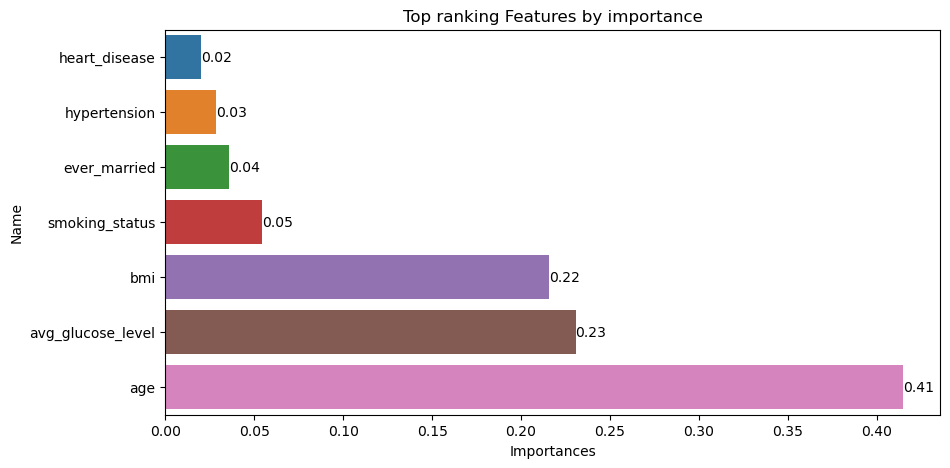

In [228]:
#we can see age, average glucose levels, and BMI as being the most important factors in predicting stroke, and with an f-1 score of 0.992, we can be pretty confident in those findings

# we can see hypertension & heart disease as not important factors for stroke risk. This is not medically true. Reason is 66 and 47 of 5110 of Hypertension & Heart Disease with Stroke Occurence is a very small popluation 
# which will lead to skewed predictive models. So in addition to age, average_glucsoe_levels and BMI, Hypertension and Heart Disease are Top Ranking Features for Detection of Stroke 

plt.rcParams["figure.figsize"] = (10,5)
feat_names = [i for i in X_train]
classed = [i for i in y_train]
feat_import_df = pd.DataFrame({'Importances': currentModel.feature_importances_, 
      'Name': feat_names}).sort_values('Importances')
groupedvalues = feat_import_df.groupby('Importances').sum().reset_index()
x = feat_import_df['Importances'].tail(9)
y = feat_import_df['Name'].tail(9)
ax = sns.barplot(x = x, y = y, data=groupedvalues)
ax.set_title('Top ranking Features by importance')
ax.bar_label(ax.containers[0], labels=None,fmt='%.2f')

In [229]:
# Numeric Importance Values for Above Graph
groupedvalues

,Importances,Name
0,0.020103,heart_disease
1,0.028669,hypertension
2,0.035819,ever_married
3,0.054236,smoking_status
4,0.215708,bmi
5,0.230608,avg_glucose_level
6,0.414856,age


<b>########################################### MODEL RUN #####################################################</b> 

In [230]:
# Functions 
def applySmokingStatus(x):
    
    if ( x['smoking_status'] == 0 ):
        x['smoking_code'] = 'unknown'
    if ( x['smoking_status'] == 1 ):
        x['smoking_code'] = 'formerly smoked'
    if ( x['smoking_status'] == 2 ):
        x['smoking_code'] = 'never smoked'
    if ( x['smoking_status'] == 3 ):
        x['smoking_code'] = 'smokes'
    return x

def applyBMI(x):
    #If your BMI is less than 18.5, it falls within the underweight range.
    #If your BMI is 18.5 to <25, it falls within the healthy weight range.
    #If your BMI is 25.0 to <30, it falls within the overweight range.
    #If your BMI is 30.0 or higher, it falls within the obesity range.
    if ( x['bmi'] < 18.5 ):
        x['bmi_index']='underweight'
    if ( (x['bmi'] >= 18.5) &  (x['bmi'] < 25) ):
        x['bmi_index']='healthy weight'
    if ( ( x['bmi'] >= 25 )  &  ( x['bmi'] < 30 ) ):
        x['bmi_index']='overweight'
    if ( x['bmi'] >= 30 ):
        x['bmi_index']='obesity'
    return x

def applyGlucoseLevels(x):
    # 70 and 100 mg/dL - normal
    # 100 to 125 mg/dL - prediabetes 
    # 126 mg/dL >= higher - diabetes
    if ( (x['avg_glucose_level'] >= 70) & (x['avg_glucose_level'] <= 100) ):
        x['glucose_level']='normal'
    elif ( ( x['avg_glucose_level'] >= 100) & (x['avg_glucose_level'] <= 125) ):
        x['glucose_level']='prediabetes'
    elif ( x['avg_glucose_level'] >= 126):
        x['glucose_level']='diabetes'
    else:
        x['glucose_level']='low'
    return x

def applyHeartStroke(x):
    if ( x['heart_stroke'] == 0 ):
        x['stroke']='No'
    else:
        x['stroke']='Yes'
    return x

In [231]:
# Load Input Model
input_data = pd.read_csv('DataSources/input_stroke_data.csv')
input_data['heart_stroke'] = currentModel.predict(input_data)

In [232]:
# Transforming Column Data from Numerics to Textual Representations. 
# E.g. bmi_index converted into underweight, healty weight, etc
input_data.insert(5, 'glucose_level', '')
input_data.insert(6, 'bmi_index', '')
input_data.insert(8, 'smoking_code', '')
input_data = input_data.apply(applySmokingStatus,axis=1)
input_data = input_data.apply(applyBMI,axis=1)
input_data = input_data.apply(applyGlucoseLevels,axis=1)
input_data = input_data.apply(applyHeartStroke,axis=1)

In [233]:
input_data.sort_values('age')

,age,hypertension,heart_disease,ever_married,avg_glucose_level,glucose_level,bmi_index,bmi,smoking_code,smoking_status,heart_stroke,stroke
4,8,0,0,0,63.43,low,healthy weight,21.800000,unknown,0,0,No
10,27,0,0,0,93.55,normal,obesity,41.600000,never smoked,2,0,No
5,28,1,0,0,80.40,normal,obesity,57.500000,never smoked,2,0,No
11,44,1,0,1,91.02,normal,obesity,32.900000,formerly smoked,1,0,No
12,55,1,0,1,91.02,normal,obesity,32.900000,formerly smoked,1,0,No
1,57,0,0,1,89.81,normal,obesity,35.600000,never smoked,2,0,No
2,58,0,0,1,189.84,diabetes,overweight,28.893237,unknown,0,1,Yes
6,59,0,0,1,211.78,diabetes,overweight,28.893237,formerly smoked,1,1,Yes
7,60,0,0,1,97.43,normal,overweight,26.400000,smokes,3,1,Yes
0,63,0,0,1,85.60,normal,overweight,25.900000,unknown,0,0,No


In [234]:
# Inferences 

#1. As Age progresses the incidence of stroke increases
#2. High Glucose Levels or Diabetes increases incidence of Stroke
#3. High BMI Levels ( Overeweight) with increasing Age increases incidence of Stroke
#4. HyperTension : You will notice that though HyperTension increases the risk of a Heart Stroke, the Stroke Event is negative. Only 13% of the Records of the Whole Population, in the initial Dataset
#5. Heart Disease : You will notice that though Heart Disease increases the risk of a Heart Stroke, the Stroke Event is negative. Only 9.8% of the Records of the Whole Population, in the initial Dataset 